# Tutorials

## Contents

- [Programmatically Generating and Scripting ODESystems](#programmatically_generating)
- [Modeling Nonlinear Systems](#modeling_nonlinear_systems)
- [Modeling Optimization Problems](#modeling_optimization_problems)
- [Modelingtoolkitize: Automatically Translating Numerical to Symbolic Code](#modlingtoolkitize)

## Programmatically Generating and Scripting ODESystems <a id="programmatically_generating" />

In the following tutorial, we will discuss how to programmatically generate ODESystems.

### The Representation of a ModelingToolkit System

ModelingToolkit is built on Symbolics.jl, a symbolic Computer Algebra System (CAS) developed in Julia. As such, all CAS functionality is also available to be used on ModelingToolkit systems, such as symbolic differentiation, Groebner basis calculations, and whatever else you can think of. 

Under the hood, all ModelingToolkit variables and expressions are Symbolics.jl variables and expressions. Thus when scripting a ModelingToolkit system, one simply needs to generate Symbolics.jl variables and equations as demonstrated in the Symbolics.jl documentation. This looks like:

In [2]:
using ModelingToolkit       # reexports Symbolics
@variables t x(t) y(t)      # Define variables
D = Differential(t)
eqs = [D(x) ~ y
       D(y) ~ x]            # Define an array of equations

2-element Vector{Equation}:
 Differential(t)(x(t)) ~ y(t)
 Differential(t)(y(t)) ~ x(t)

### The Non-DSL (non-@mtkmodel) Way of Defining an ODESystem

Using `@mtkmodel`, like in the getting started tutorial, is the preferred way of defining ODEs with MTK. However generating the contents of a `@mtkmodel` programmatically can be tedious. Let us look at how we can define the same system without `@mtkmodel`.

┌ Warning: Independent variable t should be defined with @independent_variables t.
└ @ ModelingToolkit C:\Users\jonas\.julia\packages\ModelingToolkit\klLLV\src\utils.jl:119


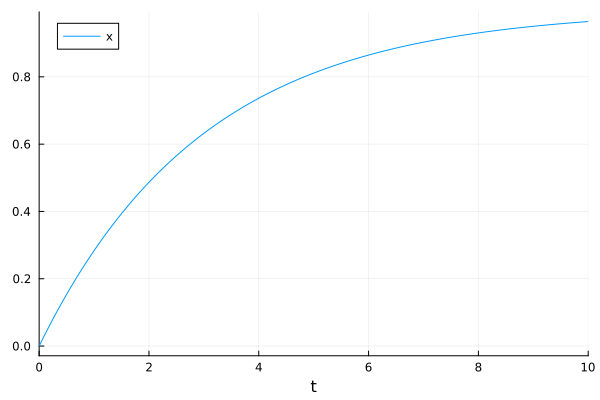

In [3]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
@variables x(t) = 0.0           # independent and dependent variables
@parameters τ = 3.0             # parameters
@constants h = 1                # constants
eqs = [D(x) ~ (h - x) / τ]      # create an array of equations

# your first ODE, consisting of a single equation, indicated by ~
@named model = ODESystem(eqs, t)

# Perform the standard transformations and mark the model complete
# Note: Complete models cannot be subsystems of other models!
fol = structural_simplify(model)
prob = ODEProblem(fol, [], (0.0, 10.0), [])
using DifferentialEquations: solve
sol = solve(prob)

using Plots
plot(sol)

As you can see, generating an ODESystem is as simple as creating an array of equations and passing it to the `ODESystem` constructor.

`@named` automatically gives a name to the ODESystem, and is shorthand for

In [4]:
fol_model = ODESystem(eqs, t; name = :fol_model)            # @named fol_model = ODESystem(eqs, t)

┌ Warning: Independent variable t should be defined with @independent_variables t.
└ @ ModelingToolkit C:\Users\jonas\.julia\packages\ModelingToolkit\klLLV\src\utils.jl:119


Model fol_model:
Equations (1):
  1 standard: see equations(fol_model)
Unknowns (1): see unknowns(fol_model)
  x(t) [defaults to 0.0]
Parameters (1): see parameters(fol_model)
  τ [defaults to 3.0]

## Modeling Nonlinear Systems <a id="modeling_nonlinear_systems" />

ModelingToolkit.jl is not only useful for generating initial value problems (`ODEProblem`). The package can also build nonlinear systems. This is, for example, useful for finding the steady state of an ODE. This steady state is reached when the nonlinear system of differential equations equals zero.

In [7]:
using ModelingToolkit, NonlinearSolve

# Define a nonlinear system
@variables x y z
@parameters σ ρ β
eqs = [0 ~ σ * (y - x)
       0 ~ x * (ρ - z) - y
       0 ~ x * y - β * z]
@mtkbuild ns = NonlinearSystem(eqs)

guesses = [x => 1.0, y => 0.0, z => 0.0]
ps = [σ => 10.0, ρ => 26.0, β => 8 / 3]

prob = NonlinearProblem(ns, guesses, ps)
sol = solve(prob, NewtonRaphson())

retcode: Success
u: 2-element Vector{Float64}:
 -2.129924444096732e-29
 -2.398137151871876e-28

Just like with `ODEProblem`s we can generate the NonlinearProblem with its analytical Jacobian function:

In [8]:
prob = NonlinearProblem(ns, guesses, ps, jac = true)
sol = solve(prob, NewtonRaphson())

retcode: Success
u: 2-element Vector{Float64}:
 -2.129924444096732e-29
 -2.398137151871876e-28

## Modeling Optimization Problems <a id="modeling_optimization_problems" />

ModelingToolkit.jl is not only useful for generating initial value problems (`ODEProblem`). The package can also build optimization systems.

### Unconstrained Rosenbrock Function

$$ (a - x)^2 + (y - x^2)^2 b$$

In [5]:
using ModelingToolkit, Optimization, OptimizationOptimJL

@variables begin
    x = 1.0, [bounds = (-2.0, 2.0)]
    y = 3.0, [bounds = (-1.0, 3.0)]
end
@parameters a=1.0 b=1.0
rosenbrock = (a - x)^2 + b * (y - x^2)^2
@mtkbuild sys = OptimizationSystem(rosenbrock, [x, y], [a, b])

Model sys:
Unknowns (2): see unknowns(sys)
  x [defaults to 1.0]
  y [defaults to 3.0]
Parameters (2): see parameters(sys)
  a [defaults to 1.0]
  b [defaults to 1.0]

Every optimization problem consists of a set of optimization variables.
In this case, we create two variables: `x` and `y`,
with initial guesses `1` and `3` for their optimal values.
Additionally, we assign box constraints for each of them, using `bounds`,
Bounds is an example of symbolic metadata.
Fore more information, take a look at the symbolic metadata.

We also create two parameters with `@parameters`.
Parameters are useful if you want to solve the same optimization problem multiple times,
with different values for these parameters.
Default values for these parameters can also be assigned, here `1` is used for both `a` and `b`.
These optimization values and parameters are used in an objective function, here the Rosenbrock function.

Next, the actual `OptimizationProblem` can be created.
The initial guesses for the optimization variables can be overwritten, via an array of `Pairs`,
in the second argument of `OptimizationProblem`.
Values for the parameters of the system can also be overwritten from their default values,
in the third argument of `OptimizationProblem`.
ModelingToolkit is also capable of constructing analytical gradients and Hessians of the objective function.

In [6]:
u0 = [y => 2.0]
p = [b => 100.0]

prob = OptimizationProblem(sys, u0, p, grad = true, hess = true)
u_opt = solve(prob, GradientDescent())

retcode: Success
u: 2-element Vector{Float64}:
 1.0000000135463598
 1.0000000271355158

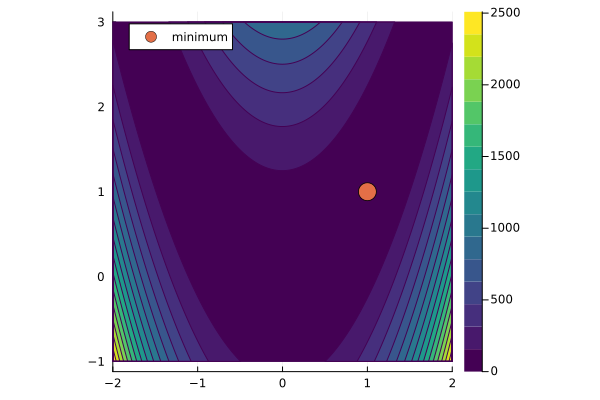

In [7]:
using Plots
x_plot = -2:0.01:2
y_plot = -1:0.01:3
contour(
    x_plot, y_plot, (x, y) -> (1 - x)^2 + 100 * (y - x^2)^2, fill = true, color = :viridis,
    ratio = :equal, xlims = (-2, 2))
scatter!([u_opt[1]], [u_opt[2]], ms = 10, label = "minimum")

### Rosenbrock Function with Constraints

ModelingToolkit is also capable of handing more complicated constraints than box constraints. Non-linear equality and inequality constraints can be added to the `OptimizationSystem`. Let's add an inequality constraint to the previous example:

In [8]:
using ModelingToolkit, Optimization, OptimizationOptimJL

@variables begin
    x = 0.14, [bounds = (-2.0, 2.0)]
    y = 0.14, [bounds = (-1.0, 3.0)]
end
@parameters a=1.0 b=100.0
rosenbrock = (a - x)^2 + b * (y - x^2)^2
cons = [
    x^2 + y^2 ≲ 1
]
@mtkbuild sys = OptimizationSystem(rosenbrock, [x, y], [a, b], constraints = cons)
prob = OptimizationProblem(sys, [], grad = true, hess = true, cons_j = true, cons_h = true)
u_opt = solve(prob, IPNewton())

┌ Warning: The selected optimization algorithm requires second order derivatives, but `SecondOrder` ADtype was not provided. 
│         So a `SecondOrder` with SciMLBase.NoAD() for both inner and outer will be created, this can be suboptimal and not work in some cases so 
│         an explicit `SecondOrder` ADtype is recommended.
└ @ OptimizationBase C:\Users\jonas\.julia\packages\OptimizationBase\gvXsf\src\cache.jl:49


retcode: Success
u: 2-element Vector{Float64}:
 0.7864151541684254
 0.6176983125233897

Inequality constraints are constructed via a `≲` (or `≳`).
[(To write these symbols in your own code write `\lesssim` or `\gtrsim` and then press tab.)](#https://docs.julialang.org/en/v1/manual/unicode-input/)
An equality constraint can be specified via a `~`, e.g., `x^2 + y^2 ~ 1`.

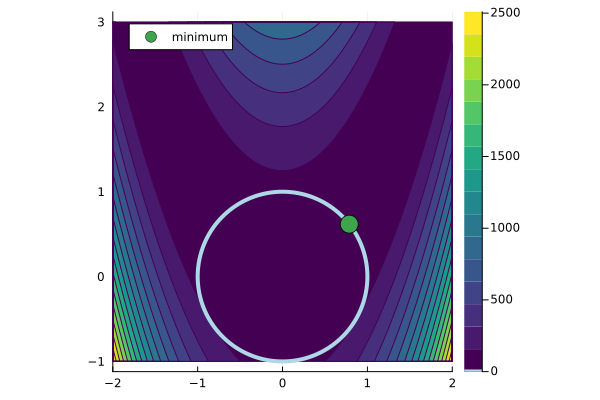

In [9]:
using Plots
x_plot = -2:0.01:2
y_plot = -1:0.01:3
contour(
    x_plot, y_plot, (x, y) -> (1 - x)^2 + 100 * (y - x^2)^2, fill = true, color = :viridis,
    ratio = :equal, xlims = (-2, 2))
contour!(x_plot, y_plot, (x, y) -> x^2 + y^2, levels = [1], color = :lightblue, line = 4)
scatter!([u_opt[1]], [u_opt[2]], ms = 10, label = "minimum")

## Modelingtoolkitize: Automatically Translating Numerical to Symbolic Code <a id="modlingtoolkitize" />